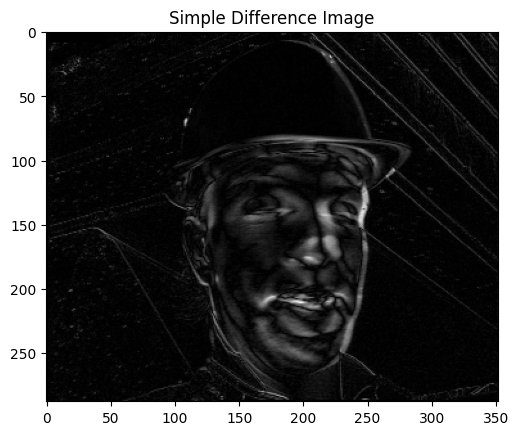

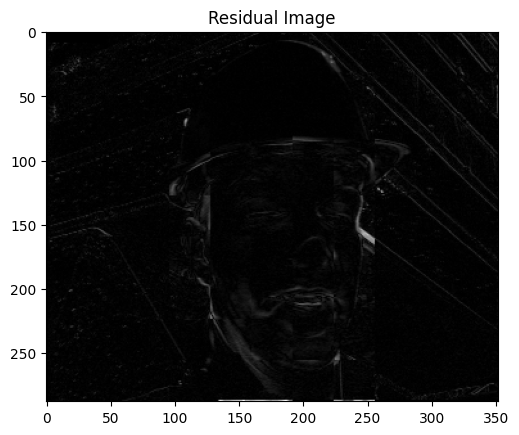

 Frame2  [[  8  38 200 ... 213 206 176]
 [  9  39 201 ... 209 207 180]
 [  9  36 205 ... 204 205 179]
 ...
 [ 16  35 105 ... 168 164 145]
 [ 15  36 105 ... 171 168 153]
 [ 15  34 103 ...  16  16  16]]
 FrameCompensated  [[  8  38 200 ... 213 206 176]
 [  9  39 201 ... 209 207 180]
 [  9  36 205 ... 204 205 179]
 ...
 [ 16  35 105 ... 168 164 145]
 [ 15  36 105 ... 171 168 153]
 [ 15  34 103 ...  16  16  16]]
 Residual Image  [[ 1  3  2 ... -2  1  1]
 [ 0 -1 -1 ...  1  0 -3]
 [ 0  0  0 ...  6  4 -3]
 ...
 [-1  1 -1 ...  2  2  5]
 [-1  0 -1 ...  0 -2 -3]
 [ 0  1  2 ...  0  0  0]]
 Simple Diff  [[1 3 2 ... 2 1 1]
 [0 1 1 ... 1 0 3]
 [0 0 0 ... 6 4 3]
 ...
 [1 1 1 ... 2 2 5]
 [1 0 1 ... 0 2 3]
 [0 1 2 ... 0 0 0]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def read_yuv_frames(filename, width, height):
    frames = []  # Initialize an empty list to store frames

    num_bytes_per_frame = width * height * 1.5  # Assuming 4:2:0 chroma subsampling; 1.5 is for combined u and v (estimating how much approx. memory is required to store a yuv frame)

    with open(filename, 'rb') as f:
        # Read data chunk by chunk based on frame size
        while True:
            yuv_data = f.read(int(num_bytes_per_frame))

            # Check for end of file (empty read)
            if not yuv_data:
                break

            # Separate Y channel
            y = yuv_data[0: width * height]

            # Reshape channels into NumPy arrays
            y = np.reshape(np.frombuffer(y, dtype=np.uint8), (height, width))

            # Convert Y channel to grayscale
            gray_frame = y
            frames.append(gray_frame)  # Add grayscale frame to the list
            # print(frames)

    return frames


# Example usage
frames = read_yuv_frames("/content/foreman.yuv", 352, 288)
frame1 = frames[1]  # Replace with actual reference frame
frame2 = frames[2]
intframe1 = frame1.astype(int)
intframe2 = frame2.astype(int)
simple_diff = np.abs(intframe1 - frame2)

# Define block size and search area
block_size = 32
search_area = 16

# Initialize motion vectors
motion_vectors = []
residual_image = np.zeros_like(intframe1)

# Iterate through each block in frame1
for y in range(0, frame1.shape[0] - block_size + 1, block_size):
    for x in range(0, frame1.shape[1] - block_size + 1, block_size):
        min_ssd = float('inf')
        best_match = (0, 0)

        # Define current block
        block1 = frame1[y:y + block_size, x:x + block_size]

        # Search in the search area of frame2
        for dy in range(-search_area, search_area + 1):
            for dx in range(-search_area, search_area + 1):
                # Define search block in frame2
                y_start = y + dy
                y_end = y + dy + block_size
                x_start = x + dx
                x_end = x + dx + block_size
                block2 = frame2[y_start:y_end, x_start:x_end]

                # Ensure search block is within frame2 boundaries
                if y_start >= 0 and y_end <= frame2.shape[0] and x_start >= 0 and x_end <= frame2.shape[1]:
                    # Calculate SSD
                    ssd = np.sum((block1 - block2) ** 2)
                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_match = (dy, dx)

        # Store motion vector for the current block
        motion_vectors.append(best_match)

        # Apply motion compensation to generate residual image
        y_end = min(y + block_size, frame2.shape[0])
        x_end = min(x + block_size, frame2.shape[1])
        residual_image[y:y_end, x:x_end] = intframe1[y:y_end, x:x_end] - intframe2[
                                                                         y + best_match[0]:y_end + best_match[0],
                                                                       x + best_match[1]:x_end + best_match[1]]

# Apply motion compensation to generate motion-compensated frame
frame_compensated = np.zeros_like(frame1)
for i, (dy, dx) in enumerate(motion_vectors):
    y = (i // (frame1.shape[1] // block_size)) * block_size
    x = (i % (frame1.shape[1] // block_size)) * block_size
    frame_compensated[y:y + block_size, x:x + block_size] = frame2[y + dy:y + dy + block_size,
                                                            x + dx:x + dx + block_size]
simple_diffs = simple_diff.astype(int)
plt.imshow(simple_diffs, cmap='gray')
plt.title('Simple Difference Image')
plt.show()
plt.imshow(np.abs(residual_image), cmap='gray')
plt.title('Residual Image')
plt.show()

print(" Frame2 ", frame2)
print(" FrameCompensated ", frame_compensated)
print(" Residual Image ", residual_image)
print(" Simple Diff ", simple_diff)
